In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import pickle

In [2]:
data = "bank-full.csv"

# Wrangle Function

In [6]:
def wrangle(filepath):
    df = pd.read_csv(filepath, delimiter=";")
    
    df.drop(columns="duration", inplace=True)
    
    return df

In [7]:
df = wrangle(data)

In [8]:
print(df.shape)
df.head()

(45211, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


In [9]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

# Split

In [10]:
target = "y"
X = df.drop(columns="y")
y = df[target]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resample

In [14]:
over_sample = RandomOverSampler(random_state=42)

In [15]:
X_train_over, y_train_over = over_sample.fit_resample(X_train, y_train)

# Build Model

# Baseline

In [18]:
baseline = df['y'].value_counts(normalize=True)[0]
print("Baseline Accuracy:", round(baseline, 4))

Baseline Accuracy: 0.883


# Iterate

In [22]:
clf = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    GradientBoostingClassifier()
)

In [23]:
params = {
    "gradientboostingclassifier__max_depth": range(2,5),
    "gradientboostingclassifier__n_estimators": range(20,31,5)
}
params

{'gradientboostingclassifier__max_depth': range(2, 5),
 'gradientboostingclassifier__n_estimators': range(20, 31, 5)}

In [27]:
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1, verbose=1)

In [28]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5)},
             verbose=1)

In [29]:
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30}

# Evaluate

In [31]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.781
Test Accuracy: 0.7773


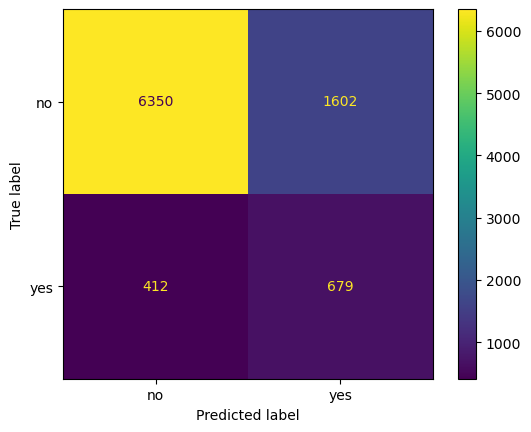

In [34]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [37]:
print(classification_report(y_test, y_pred=model.predict(X_test)))

              precision    recall  f1-score   support

          no       0.94      0.80      0.86      7952
         yes       0.30      0.62      0.40      1091

    accuracy                           0.78      9043
   macro avg       0.62      0.71      0.63      9043
weighted avg       0.86      0.78      0.81      9043



In [57]:
def make_cnf_matrix(threshold):
    y_predict_prob = model.predict_proba(X_test)[:, -1]
    y_predict = y_predict_prob > threshold
    y_pred_str = np.where(y_predict, "yes", "no")
    conf_matrix = confusion_matrix(y_test, y_pred_str)
    tn, fp, fn, tp = conf_matrix.ravel()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_str, colorbar=False)

thresh_widget = widgets.FloatSlider(min=0, max=1, value=0.5, steps=0.05)
interact(make_cnf_matrix, threshold=thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0), Output()), _dom_classes=('widg…

In [59]:
with open("GSclassificaiton_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [60]:
def make_my_prediction(data_filepath, model_filepath):
    #Wrangle data file
    X_test = wrangle(data_filepath)
    
    #Load model
    with open("GSclassificaiton_model.pkl", "rb") as f:
        model = pickle.load(f)
        
    #Generate Predictions
    y_test_pred = model.predict(X_test)
    
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="Subscribed to Campaign")
    return y_test_pred

In [62]:
%%writefile Predictor.py
#import liraries
import pandas as pd

def wrangle(filepath):
    df = pd.read_csv(filepath, delimiter=";")
    
    df.drop(columns="duration", inplace=True)
    
    return df

def make_my_prediction(data_filepath, model_filepath):
    #Wrangle data file
    X_test = wrangle(data_filepath)
    
    #Load model
    with open("GSclassificaiton_model.pkl", "rb") as f:
        model = pickle.load(f)
        
    #Generate Predictions
    y_test_pred = model.predict(X_test)
    
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="Subscribed to Campaign")
    return y_test_pred

Writing Predictor.py


In [67]:
!type Predictor.py

#import liraries
import pandas as pd

def wrangle(filepath):
    df = pd.read_csv(filepath, delimiter=";")
    
    df.drop(columns="duration", inplace=True)
    
    return df

def make_my_prediction(data_filepath, model_filepath):
    #Wrangle data file
    X_test = wrangle(data_filepath)
    
    #Load model
    with open("GSclassificaiton_model.pkl", "rb") as f:
        model = pickle.load(f)
        
    #Generate Predictions
    y_test_pred = model.predict(X_test)
    
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="Subscribed to Campaign")
    return y_test_pred
